In [10]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import emcee
import torch
import sacc
import corner
import os
import itertools
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import qmc
import arviz as az  # ArviZ is useful for MCMC diagnostics
import matplotlib.pyplot as plt
from matplotlib import colors
import arviz as az
import seaborn as sns

from copy import deepcopy

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from time import time
from importlib import reload
reload(training)
reload(models)

seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.use_deterministic_algorithms(False)

# set matplotlib plotting style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

# set device for all tensors
device = 'cuda'

In [11]:
# Load in mcmc data sets

# load in the data
numerical_reader = emcee.backends.HDFBackend('mcmc/76walkers_chain_outputs_CCL.h5', read_only=True)
# pretrain_reader = emcee.backends.HDFBackend('mcmc/iterative_pretrain_emulator_mcmc_50tau.h5', read_only=True)
# fresh_reader = emcee.backends.HDFBackend('mcmc/iterative_fresh_emulator_mcmc_50tau.h5', read_only=True)
# maml_reader = emcee.backends.HDFBackend('mcmc/iterative_maml_emulator_mcmc_50tau.h5', read_only=True)

numerical_reader = emcee.backends.HDFBackend('mcmc/76walkers_chain_outputs_CCL.h5', read_only=True)
pretrain_reader = emcee.backends.HDFBackend('mcmc/76_pretrain_emulator_mcmc_50tau.h5', read_only=True)
fresh_reader = emcee.backends.HDFBackend('mcmc/76_fresh_emulator_mcmc_50tau.h5', read_only=True)
maml_reader = emcee.backends.HDFBackend('mcmc/76_maml_emulator_mcmc_50tau.h5', read_only=True)

# # Save numerical data to new file without blobs
# numerical_chain = numerical_reader.get_chain()
# numerical_log_prob = numerical_reader.get_log_prob()
# numerical_acceptance = numerical_reader.get_blobs()
# fname = 'mcmc/76walkers_chain_outputs_no_blobs.h5'
# with h5.File(fname, 'w') as f:
#     f.create_dataset('chain', data=numerical_chain)
#     f.create_dataset('log_prob', data=numerical_log_prob)
#     f.create_dataset('acceptance', data=numerical_acceptance)

In [12]:
# Print max autocorr length
print('Numerical max autocorr length:', np.max(numerical_reader.get_autocorr_time()))
print('Pretrain max autocorr length:', np.max(pretrain_reader.get_autocorr_time()))
print('Fresh max autocorr length:', np.max(fresh_reader.get_autocorr_time()))
print('MAML max autocorr length:', np.max(maml_reader.get_autocorr_time()))

Numerical max autocorr length: 272.52335960260916
Pretrain max autocorr length: 313.7243890492108
Fresh max autocorr length: 348.16573350395095
MAML max autocorr length: 336.18795253278165


In [13]:
# def calculate_ESS(reader):
#     tau = reader.get_autocorr_time()
#     n_walkers, n_samples, n_dim = reader.get_chain().shape
#     ess = (n_samples * n_walkers) / (1 + 2 * np.sum(tau))
#     return ess

# print('Numerical ESS:', calculate_ESS(numerical_reader))
# print('Pretrain ESS:', calculate_ESS(pretrain_reader))
# print('Fresh ESS:', calculate_ESS(fresh_reader))
# print('MAML ESS:', calculate_ESS(maml_reader))

In [14]:
numerical_samples = numerical_reader.get_chain(discard=1000, flat=True)[:,:5]
pretrain_samples = pretrain_reader.get_chain(discard=1000, flat=True)[:,:5]
fresh_samples = fresh_reader.get_chain(discard=1000, flat=True)[:,:5]
maml_samples = maml_reader.get_chain(discard=1000, flat=True)[:,:5]

print(len(numerical_samples))
print(len(pretrain_samples))
print(len(fresh_samples))
print(len(maml_samples))

# Compute Rhat
# num_rhat = az.rhat(numerical_samples)
# pretrain_rhat = az.rhat(pretrain_samples)
# fresh_rhat = az.rhat(fresh_samples)
# maml_rhat = az.rhat(maml_samples)

# print('Numerical Rhat:', num_rhat)
# print('Pretrain Rhat:', pretrain_rhat)
# print('Fresh Rhat:', fresh_rhat)
# print('MAML Rhat:', maml_rhat)

988000
1140000
1292000
1216000


In [15]:
# Combine Omega_c and Omega_b to Omega_m
Omega_m = numerical_samples[:,0] + numerical_samples[:,1]
numerical_samples = np.concatenate((Omega_m[:,None], numerical_samples[:,2:]), axis=1)

Omega_m = pretrain_samples[:,0] + pretrain_samples[:,1]
pretrain_samples = np.concatenate((Omega_m[:,None], pretrain_samples[:,2:]), axis=1)

Omega_m = fresh_samples[:,0] + fresh_samples[:,1]
fresh_samples = np.concatenate((Omega_m[:,None], fresh_samples[:,2:]), axis=1)

Omega_m = maml_samples[:,0] + maml_samples[:,1]
maml_samples = np.concatenate((Omega_m[:,None], maml_samples[:,2:]), axis=1)

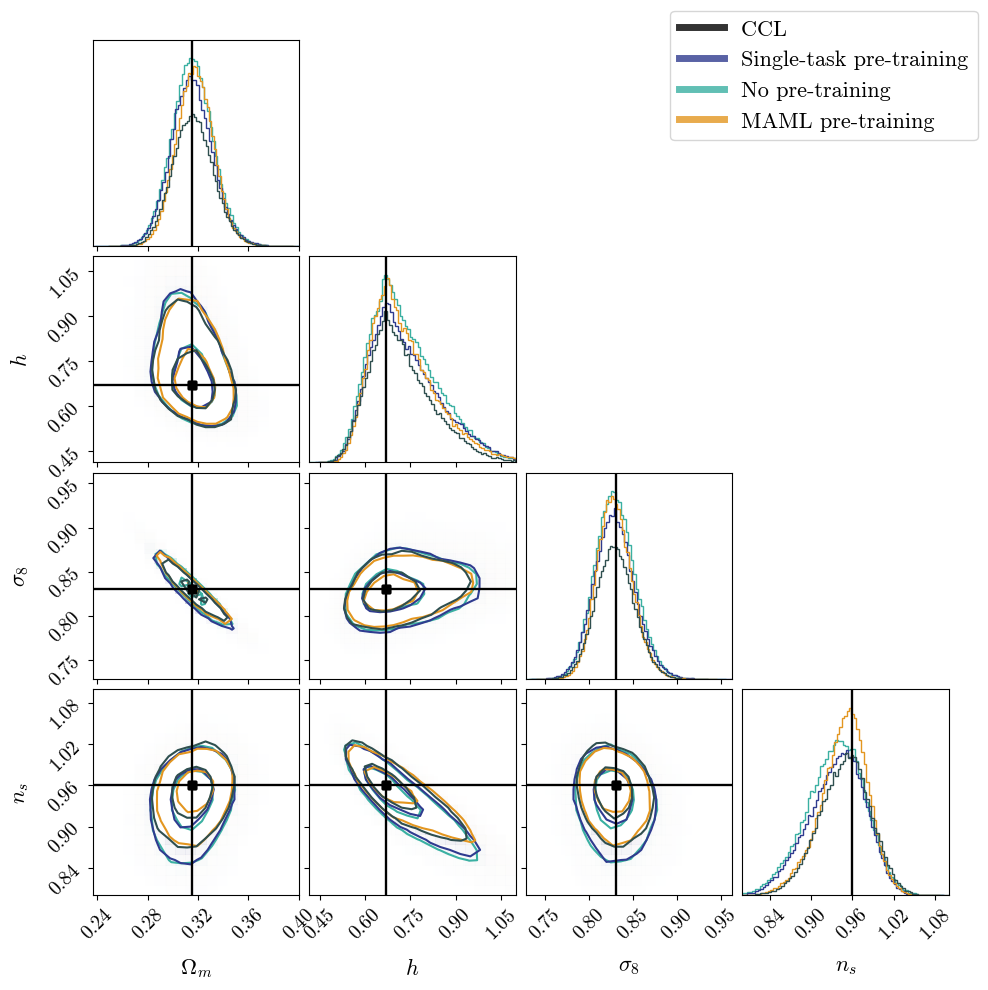

In [16]:

theta_fid = np.array([0.27+0.045, 0.67, 0.83, 0.96])
param_ranges = None #[(0.2, 0.5), (0.4, 1.1), (0.6, 1.0), (0.8, 1.1)]
smooth = 0
bins = 20
hist_factor = 4
levels = [0.393, 0.865]

colors_pop = ["#2F3B8F", "#3AB0A2", "#E39620"]

labels = [r"$\Omega_m$", r"$h$", r"$\sigma_8$", r"$n_s$", r"$\delta^z_1$", r"$\delta^z_2$", ]

fig = plt.figure(figsize=(10, 10))

# Add fresh samples
corner.corner(
    fresh_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color=colors_pop[1],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    fig=fig
)

# Add emulator samples
corner.corner(
    pretrain_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color=colors_pop[0],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    fig=fig
)

# Add MAML samples
corner.corner(
    maml_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color=colors_pop[2],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    fig=fig
)

# Plot the corner plot
corner.corner(
    numerical_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=False,
    color='darkslategray',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    label_kwargs={'fontsize': 16},
    fig=fig
)


handles = [
    plt.Line2D([0], [0], color='k', lw=5, alpha=0.8, label='CCL '),
    plt.Line2D([0], [0], color=colors_pop[0], lw=5, alpha=0.8, label='Single-task pre-training'),
    plt.Line2D([0], [0], color=colors_pop[1], lw=5, alpha=0.8, label='No pre-training'),
    plt.Line2D([0], [0], color=colors_pop[2], lw=5, alpha=0.8, label='MAML pre-training')
]

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=14)

fig.legend(handles=handles, loc='upper right', fontsize=16)
plt.savefig('mcmc/mcmc_compare_emulators.pdf', bbox_inches='tight', dpi=300)

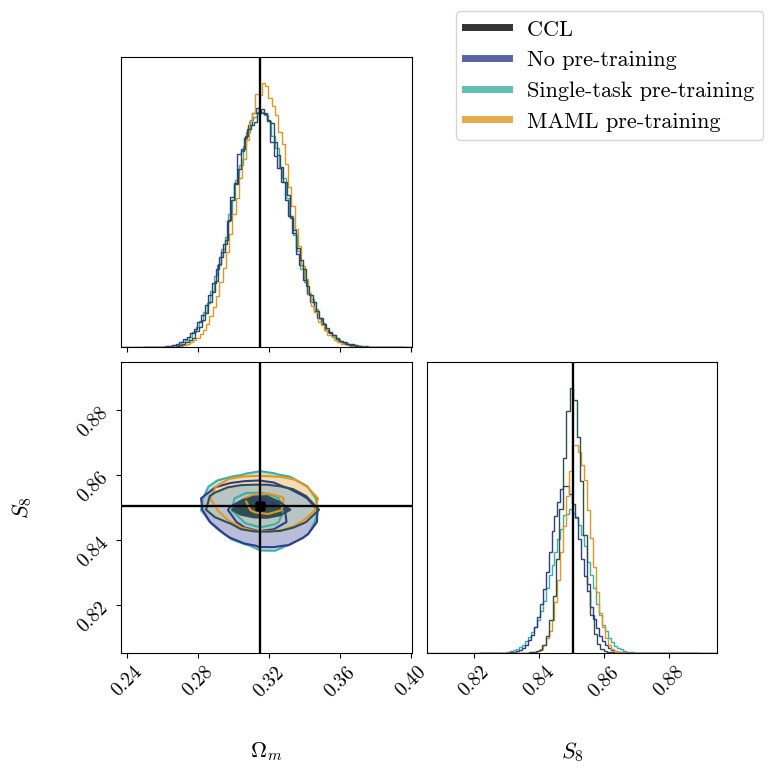

In [17]:
# Compute S8 values for each chain
def compute_S8(Omega_m, sigma8):
    return sigma8 * (Omega_m / 0.3)**0.5

S8_numerical = compute_S8(numerical_samples[:,0], numerical_samples[:,2])
S8_num_samples = np.vstack((numerical_samples[:,0], S8_numerical)).T

S8_pretrain = compute_S8(pretrain_samples[:,0], pretrain_samples[:,2])
S8_pretrain_samples = np.vstack((pretrain_samples[:,0], S8_pretrain)).T

S8_fresh = compute_S8(fresh_samples[:,0], fresh_samples[:,2])
S8_fresh_samples = np.vstack((fresh_samples[:,0], S8_fresh)).T

S8_maml = compute_S8(maml_samples[:,0], maml_samples[:,2])
S8_maml_samples = np.vstack((maml_samples[:,0], S8_maml)).T

truths = [theta_fid[0], compute_S8(theta_fid[0], theta_fid[2])]
levels = [0.393, 0.865]
smooth = 0
bins = 20
hist_factor = 4
param_ranges = None
fill = True

fig = plt.figure(figsize=(8, 8))

colors=['#4059AD', '#97D8C4', '#F4B942']
colors_pop = ["#2F3B8F", "#3AB0A2", "#E39620"]

# Add fresh samples
corner.corner(
    S8_fresh_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color=colors_pop[1],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    hist_kwargs=dict(density=True),
    range=param_ranges,
    fig=fig
)

# Add emulator samples
corner.corner(
    S8_pretrain_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color=colors_pop[0],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    hist_kwargs=dict(density=True),
    range=param_ranges,
    fig=fig
)

# Add MAML samples
corner.corner(
    S8_maml_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color=colors_pop[2],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    hist_kwargs=dict(density=True),
    range=param_ranges,
    fig=fig
)

# Plot the corner plot
corner.corner(
    S8_num_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color='darkslategray',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    label_kwargs={'fontsize': 16},
    hist_kwargs=dict(density=True),
    fig=fig
)

handles = [
    plt.Line2D([0], [0], color='k', lw=5, alpha=0.8, label='CCL '),
    plt.Line2D([0], [0], color=colors_pop[0], lw=5, alpha=0.8, label='No pre-training'),
    plt.Line2D([0], [0], color=colors_pop[1], lw=5, alpha=0.8, label='Single-task pre-training'),
    plt.Line2D([0], [0], color=colors_pop[2], lw=5, alpha=0.8, label='MAML pre-training')
]

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=14)

fig.legend(handles=handles, loc='upper right', fontsize=16)

plt.savefig('plots/S8_compare_emulators.pdf', bbox_inches='tight', dpi=300)

Fine-tuning with a validation check instead of a set number of epochs appears to worsen the performance of the MAML model. Investigate further.
We observe increasing fine-tuning epochs up to 128 improves single task emulator but worsens MAML emulator.
Fine-tuning with 32 epochs has little effect on the performance of MAML but significantly worsens the performance of the pre-trained model

Seed 456, 363

In [18]:
def extract_summary_stats(samples, parameter_names=["Omega_m", "S8"]):
    """
    Compute median and 1σ uncertainties for parameters from posterior samples.
    
    Parameters:
    - samples: np.array of shape (N, 2), where each row is a sample [S8, Omega_m]
    - parameter_names: List of parameter names for reporting.
    
    Returns:
    - Dictionary with median and ±1σ uncertainties.
    """
    results = {}
    for i, param in enumerate(parameter_names):
        median = np.median(samples[:, i])
        lower = np.percentile(samples[:, i], 16)  # 16th percentile (1σ lower bound)
        upper = np.percentile(samples[:, i], 84)  # 84th percentile (1σ upper bound)
        err_lower = median - lower
        err_upper = upper - median
        results[param] = {"median": median, "1σ_lower": err_lower, "1σ_upper": err_upper}
    return results

# Extract statistics
summary_stats = {
    "CCL" : extract_summary_stats(S8_num_samples),
    "No pre-training" : extract_summary_stats(S8_fresh_samples),
    "Single-task pre-training" : extract_summary_stats(S8_pretrain_samples),
    "MAML pre-training" : extract_summary_stats(S8_maml_samples)
}

print('Fiducial values')
print('S8:', compute_S8(theta_fid[0], theta_fid[2]))
print('Omega_m:', theta_fid[0])

# Print results in LaTeX format for a paper
for key, stats in summary_stats.items():
    print(key)
    for param, values in stats.items():
        print(f"{param}: {values['median']:.3f}^{{+{values['1σ_upper']:.3f}}}_{{-{values['1σ_lower']:.3f}}}")

Fiducial values
S8: 0.8504969135746467
Omega_m: 0.315
CCL
Omega_m: 0.316^{+0.016}_{-0.016}
S8: 0.850^{+0.003}_{-0.003}
No pre-training
Omega_m: 0.315^{+0.016}_{-0.016}
S8: 0.850^{+0.006}_{-0.006}
Single-task pre-training
Omega_m: 0.314^{+0.016}_{-0.016}
S8: 0.848^{+0.005}_{-0.005}
MAML pre-training
Omega_m: 0.317^{+0.014}_{-0.015}
S8: 0.852^{+0.004}_{-0.004}


In [19]:
import numpy as np
import corner
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean
from scipy.linalg import det, inv

def get_contour_hull(samples, sigma_level):
    """Compute the convex hull enclosing the given credibility level of the posterior."""
    hist, x_edges, y_edges = np.histogram2d(samples[:, 0], samples[:, 1], bins=50)
    
    hist_flat = hist.ravel()
    sorted_indices = np.argsort(hist_flat)[::-1]
    cumsum = np.cumsum(hist_flat[sorted_indices]) / np.sum(hist_flat)

    threshold_index = np.argmax(cumsum >= sigma_level)
    threshold = hist_flat[sorted_indices][threshold_index]

    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    X, Y = np.meshgrid(x_centers, y_centers)
    mask = hist >= threshold

    points = np.vstack([X[mask], Y[mask]]).T
    return ConvexHull(points) if len(points) >= 3 else None

def bhattacharyya_distance(fid_samples, emul_samples):
    """Compute Bhattacharyya Distance between fiducial and emulator posteriors."""
    # Compute means
    mu_fid = np.mean(fid_samples, axis=0)
    mu_emul = np.mean(emul_samples, axis=0)

    # Compute covariance matrices
    cov_fid = np.cov(fid_samples, rowvar=False)
    cov_emul = np.cov(emul_samples, rowvar=False)

    # Compute average covariance
    cov_avg = 0.5 * (cov_fid + cov_emul)

    # Compute Mahalanobis distance (centroid shift)
    mean_diff = mu_fid - mu_emul
    mahalanobis_term = 0.125 * mean_diff.T @ inv(cov_avg) @ mean_diff

    # Compute determinant ratio term
    det_ratio = det(cov_avg) / np.sqrt(det(cov_fid) * det(cov_emul))
    log_term = 0.5 * np.log(det_ratio)

    return mahalanobis_term + log_term

def evaluate_emulator(fid_samples, emul_samples):
    """Compute coverage, centroid shift, and Bhattacharyya distance."""
    hull_1sigma_fid = get_contour_hull(fid_samples, 0.393)
    hull_2sigma_fid = get_contour_hull(fid_samples, 0.865)
    
    hull_1sigma_emul = get_contour_hull(emul_samples, 0.393)
    hull_2sigma_emul = get_contour_hull(emul_samples, 0.865)

    coverage_1sigma = hull_1sigma_emul.volume / hull_1sigma_fid.volume if hull_1sigma_emul else None
    coverage_2sigma = hull_2sigma_emul.volume / hull_2sigma_fid.volume if hull_2sigma_emul else None

    bhatta_dist = bhattacharyya_distance(fid_samples, emul_samples)

    return coverage_1sigma, coverage_2sigma, bhatta_dist

# Example usage

# Compute relative coverage
coverages = {
    "Pretrain emulator": evaluate_emulator(S8_num_samples, S8_pretrain_samples),
    "Fresh emulator": evaluate_emulator(S8_num_samples, S8_fresh_samples),
    
    "MAML emulator": evaluate_emulator(S8_num_samples, S8_maml_samples),
}

# Print results
for label, (cov1, cov2, bd) in coverages.items():
    print(f"{label}: 1σ Coverage = {cov1:.2f}, 2σ Coverage = {cov2:.2f}, Bhattacharyya Distance = {bd:.2f}")


Pretrain emulator: 1σ Coverage = 1.67, 2σ Coverage = 1.64, Bhattacharyya Distance = 0.07
Fresh emulator: 1σ Coverage = 2.08, 2σ Coverage = 1.94, Bhattacharyya Distance = 0.08
MAML emulator: 1σ Coverage = 1.24, 2σ Coverage = 1.15, Bhattacharyya Distance = 0.04
